# Bibliotecas

In [1]:
import pickle
import warnings

import numpy    as np
import pandas   as pd
import seaborn  as sns

from matplotlib         import pyplot as plt
from sklearn.metrics    import mean_absolute_error, mean_absolute_percentage_error

warnings.filterwarnings( 'ignore' )

# Importação de dados

In [2]:
X_test = pd.read_pickle('../exports/cicle_exports/06_feature_selection/X_test.pkl', compression='gzip')
y_test = pd.read_pickle('../exports/cicle_exports/06_feature_selection/y_test.pkl', compression='gzip')

y_pred = pickle.load(open( '../exports/cicle_exports/08_fine_tuning/y_pred.pkl', 'rb'))

# 9.0. Interpretação e tradução do erro

In [3]:
# Preparação do dataframe para análise do erro:
df9 = X_test

# Reescalando variáveis à escala original:
df9['sales'] = np.expm1( y_test )    # exp, pois a variável tinha sido transformada para escala logarítmica para seleção de variáveis 
df9['predictions']  = np.expm1( y_pred )    # exp, pois a variável tinha sido transformada para escala logarítmica para seleção de variáveis 

## 9.1. Performance do modelo sobre o negócio por loja

In [4]:
# Soma das previsões:
df9_1 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE e MAPE:
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge:
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df9_2 = pd.merge( df9_1, df9_aux3, how='inner', on='store' )

# Elaboração de cenários:
df9_2['worst_scenario'] = df9_2['predictions'] - df9_2['MAE']
df9_2['best_scenario'] = df9_2['predictions'] + df9_2['MAE']

# Ordenamento de colunas:
df9_2 = df9_2[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [5]:
# Exibição dos cenários por de previsão de receita loja:
df9_2.sort_values( 'MAPE', ascending=False ).round(2)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
643,644,4.935629e+05,488505.58,498620.30,5057.36,0.52
840,841,4.741647e+05,472717.34,475612.10,1447.38,0.47
285,286,6.533201e+05,651884.51,654755.74,1435.62,0.44
769,770,8.220252e+05,820109.69,823940.81,1915.56,0.41
169,170,6.718903e+05,670495.82,673284.80,1394.49,0.33
...,...,...,...,...,...,...
948,949,6.137622e+05,613341.67,614182.83,420.58,0.08
922,923,6.287623e+05,628349.16,629175.46,413.15,0.07
732,733,2.147665e+06,2146534.98,2148795.52,1130.27,0.07
1052,1053,1.030724e+06,1030065.15,1031382.48,658.67,0.07


<Axes: xlabel='store', ylabel='MAPE'>

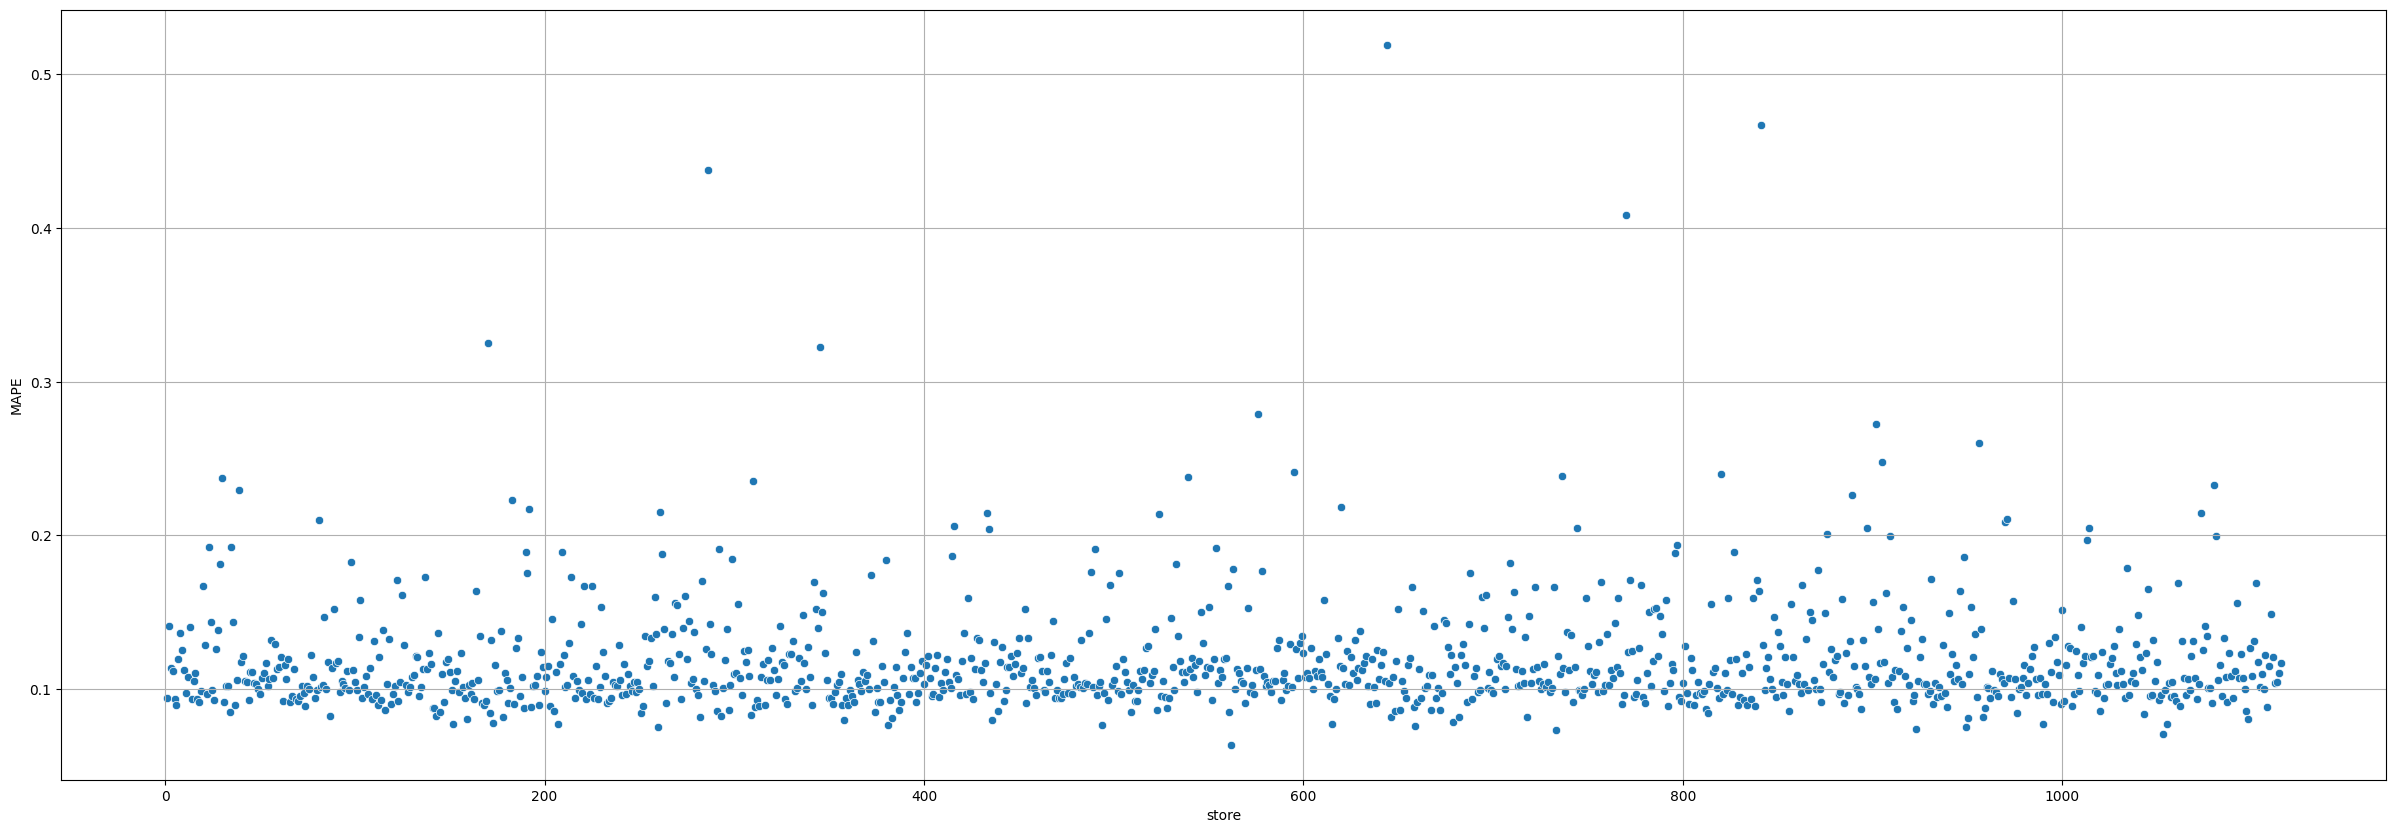

In [6]:
# Plotando o erro dos cenários de previsão de receita cenários por loja:
plt.figure(figsize=(30, 10))
plt.grid(True)
sns.scatterplot( x='store', y='MAPE', data=df9_2 )

## 9.2. Performance geral do modelo sobre o negócio

In [7]:
# Cenários gerais de previsão de receita:
df9_3 = df9_2[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df9_3['Values'] = df9_3['Values'].map( '$ {:,.2f}'.format )
df9_3

,Scenario,Values
0,predictions,"$ 889,008,192.00"
1,worst_scenario,"$ 888,045,861.31"
2,best_scenario,"$ 889,970,509.13"


## 9.3. Performance de aprendizado do modelo

In [8]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<Axes: xlabel='predictions', ylabel='error'>

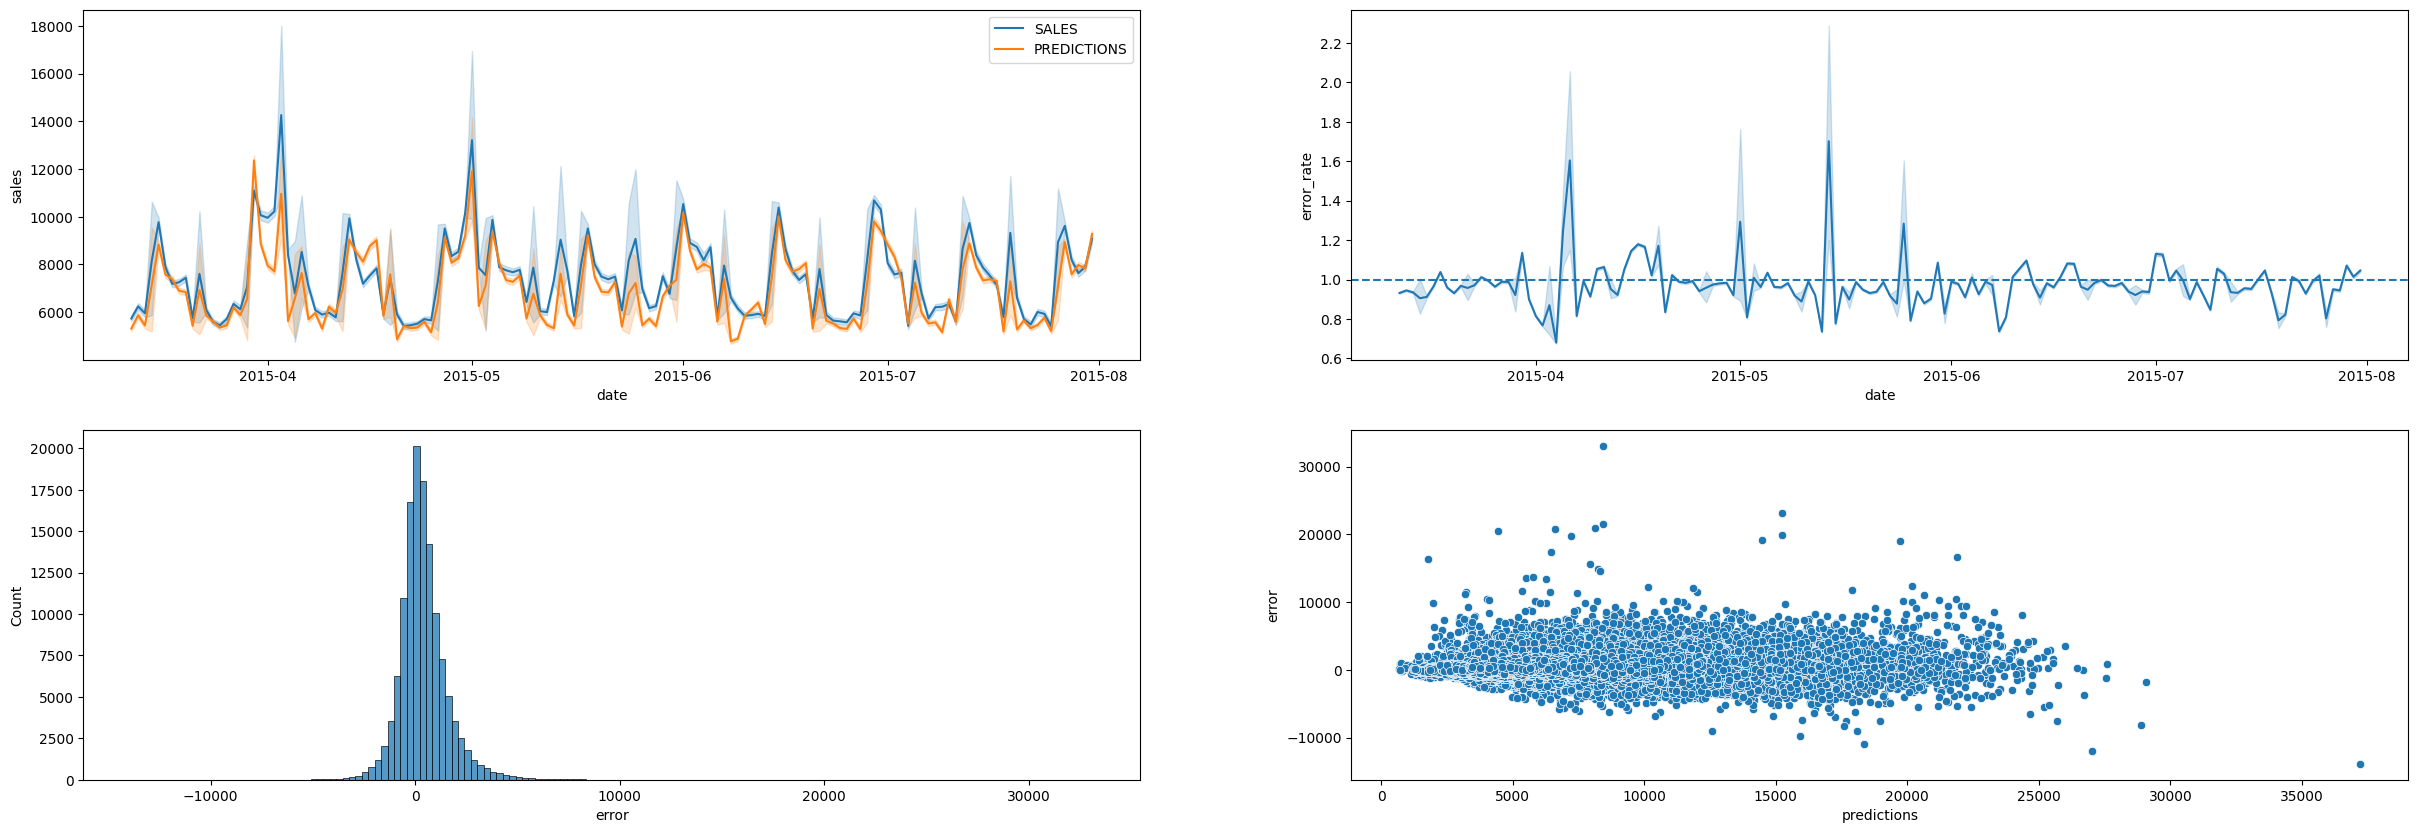

In [9]:
plt.figure(figsize=(30, 10))

# Comparação dos dados previstos em relação à base real de teste:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

# Variação da previsão em relação ao resultados real da base de teste:
plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

# Distribuição do erro da previsão em relação à base de teste:
plt.subplot( 2, 2, 3 )
sns.histplot( df9['error'], bins=150 )

# Distribuição do erro em relação à intensidade do valor previsto:
plt.subplot( 2, 2, 4 )
sns.scatterplot( x=df9['predictions'], y=df9['error'] )